In [68]:
import pandas as pd

ip = {'inplace': True}

In [69]:
import gpxpy

def gpx_to_pandas(path):
    with open(path) as f:
        gpx = gpxpy.parse(f)

    pts = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                pts.append({
                    'time': point.time,
                    'lat': point.latitude,
                    'lon': point.longitude,
                    'elv': point.elevation,
                })
    return pd.DataFrame(pts)

trk = gpx_to_pandas('walk.gpx')
trk

,time,lat,lon,elv
0,2025-03-13 19:32:03+00:00,52.426254,10.789862,109.2
1,2025-03-13 19:32:09+00:00,52.426190,10.789854,107.9
2,2025-03-13 19:32:15+00:00,52.426136,10.789795,107.0
3,2025-03-13 19:32:21+00:00,52.426066,10.789801,106.4
4,2025-03-13 19:32:27+00:00,52.425995,10.789738,103.2
...,...,...,...,...
72,2025-03-13 19:39:15+00:00,52.426679,10.789916,112.8
73,2025-03-13 19:39:21+00:00,52.426697,10.789870,111.1
74,2025-03-13 19:39:27+00:00,52.426702,10.789784,108.1
75,2025-03-13 19:39:43+00:00,52.426699,10.789760,105.0


In [ ]:
import json
# pd.options.display.max_columns = None
# pd.options.display.max_rows= None

def load_lights() -> pd.DataFrame:
    data = json.load(open('../data/traffic_signals.json'))
    lights = pd.DataFrame(data['elements'])
    lights.drop(columns=['type'], **ip)
    return lights

lights = load_lights()
lights = lights[lights['id'] == 112546381] # porschestrasse lights

In [71]:
import math

def add_dist(row, pt):
    return math.sqrt((row['lat'] - pt['lat'])**2 + (row['lon'] - pt['lon'])**2)

# Apply the function to frame1 and get the minimum distance for each point
trk['dist'] = trk.apply(add_dist, axis=1, pt=lights)

/tmp/ipykernel_59852/3214569083.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.sqrt((row['lat'] - pt['lat'])**2 + (row['lon'] - pt['lon'])**2)


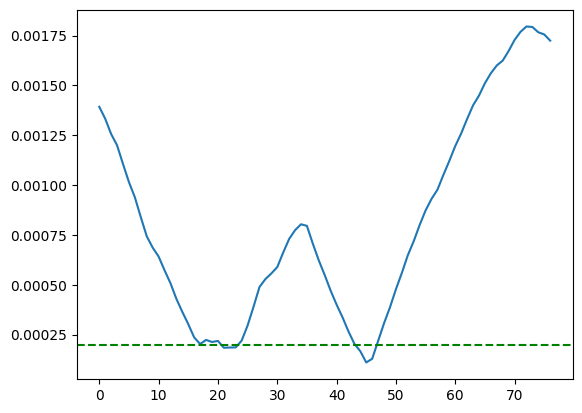

In [72]:
ax = trk['dist'].plot(x='time')
ax.axhline(y=.0002, color='g', linestyle='--', label='y = .0002')

In [73]:
def find_crossing(trk):
    low_threshold = .0003  # Threshold to start tracking when the value is below this
    high_threshold = .0005  # Threshold to reset tracking when the value exceeds this

    # Initialize variables to track the lowest point
    lowest_value = float('inf')
    lowest_index = None
    tracking = False

    # Iterate through rows of the DataFrame to track the lowest value
    for idx, row in trk.iterrows():
        value = row['dist']
        
        # print(f"Processing index {idx}: dist={value}")

        if value < low_threshold:
            if not tracking:
                # Start tracking when the value is below the low threshold
                tracking = True
                lowest_value = value
                lowest_index = idx
                # print(f"Started tracking at index {idx} with value {value}")
            elif value < lowest_value:
                # Update the lowest value if it's lower than the current one
                lowest_value = value
                lowest_index = idx
                # print(f"New lowest value {lowest_value} at index {lowest_index}")
        elif value > high_threshold:
            # Reset tracking when the value exceeds the high threshold
            # if tracking:
                # print(f"Resetting tracking at index {idx} with value {value}")
            tracking = False
            lowest_value = float('inf')
            if lowest_index:
                yield trk['time'].iloc[lowest_index]
            lowest_index = None

    # Return the index of the lowest value found or None if no crossing occurred
    # if lowest_index is None:
    #     print("No value below the low threshold was found.")
    if lowest_index:
        yield trk['time'].iloc[lowest_index]


In [74]:
df = pd.DataFrame(find_crossing(trk), columns=['time'])
df

,time
0,2025-03-13 19:34:09+00:00
1,2025-03-13 19:36:33+00:00


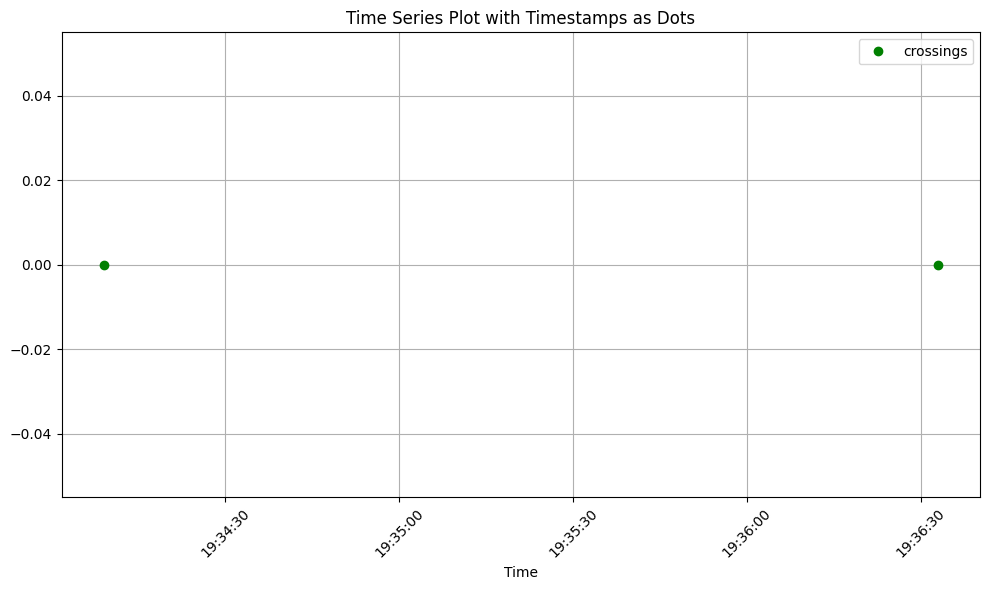

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: Assuming 'timestamps' is a list of timestamps and 'values' could be any associated data.
# Let's assume you have a DataFrame `df` with the timestamps in 'timestamp' column.

# Example DataFrame with timestamps (you can replace this with your actual DataFrame)
# Plotting the time series

df['time'] = df['time'].dt.tz_localize(None) 
# df['time'] = pd.to_datetime(df['time'], errors='coerce')
# df = df.dropna(subset=['time'])

plt.figure(figsize=(10, 6))

# Plot dots (markers) for each timestamp
times = df['time']
# plt.plot(times.index, data.values, label="Original Data", marker="o")
plt.plot(df['time'], [0]*len(df), 'go', label='crossings')  # 'bo' stands for blue dots

# Formatting the plot
plt.xlabel('Time')
# plt.ylabel('Values')
plt.title('Time Series Plot with Timestamps as Dots')
plt.xticks(rotation=45)  # Rotate the x-axis labels for readability
plt.grid(True)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_59852/4208640596.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(start="2025-03-01", periods=10, freq="5T")  # 10 timestamps with 5-minute interval
/tmp/ipykernel_59852/4208640596.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  new_timestamps = pd.date_range(start=timestamps.min(), end=timestamps.max(), freq="90S")


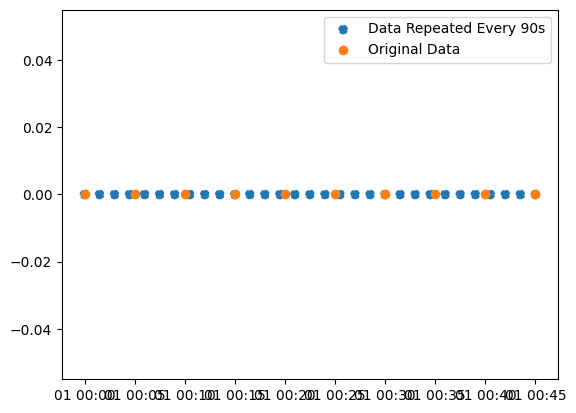

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace this with your actual data)
timestamps = pd.date_range(start="2025-03-01", periods=10, freq="5T")  # 10 timestamps with 5-minute interval
data = pd.Series(range(10), index=timestamps)

# Create a new datetime range with 90 seconds interval
new_timestamps = pd.date_range(start=timestamps.min(), end=timestamps.max(), freq="90S")
new_data = data.reindex(new_timestamps, method="ffill")  # Forward fill to replicate the last value
plt.scatter(new_data.index, [0]*len(new_data), label="Data Repeated Every 90s", linestyle='--')

# Repeat the data over the new time range, duplicating the values

# Plot the original data and the new data with 90-second intervals
plt.scatter(data.index, [0]*len(data), label="Original Data", marker="o")
plt.legend()
plt.show()


- does it fit if each points repeats every
  - 60s
  - 90s
  - 120s

In [ ]:
# import math

# delta = .006
# within_range = (trk['lat'] - lights['lat'].iloc[0] < delta) & (trk['lon'] - lights['lon'].iloc[0] < delta)
# trk['dist'] = math.sqrt(trk['lat']**2 + trk['lon']**2)
# within = trk[within_range]
# within.head()

In [ ]:
import folium

# Define the initial location for the map (center point)
map_center = [lights['lat'].mean(), lights['lon'].mean()]
osm_map = folium.Map(location=map_center, zoom_start=14, tiles="OpenStreetMap")

# Add scatter points to the map
for _, row in lights.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        # popup=row['label'],
        color="blue",
        fill=True,
        fill_color="blue"
    ).add_to(osm_map)

wob42 = [52.4267246, 10.7897581]
folium.Marker(location=wob42).add_to(osm_map)

folium.PolyLine(
    locations=within[['lat', 'lon']].values,
    color="#FF0000",
    weight=5
).add_to(osm_map)

# Show map in Jupyter Notebook
osm_map

NameError: name 'within' is not defined

In [ ]:
from math import sqrt
from gpxpy.gpx import GPXWaypoint

def gpx_dist(w1: GPXWaypoint, w2: GPXWaypoint):
    """Cartesian distance btw. two waypoints"""
    return sqrt((w1.latitude - w2.latitude)**2 + (w1.longitude - w2.longitude)**2)